In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchgeometry as tgm

### Inputs

In [29]:
input_dir = './data'
root_dir = os.path.join(input_dir, 'training')
sequence_name = 'alley_1'
frame_i_id = 3
frame_ref_id = 1

### Utility functions

In [30]:
def load_data(root_path, sequence_name, frame_id):
    # index paths                                                                                                                        
    file_name = 'frame_%04d' % (frame_id)
    image_file = os.path.join(root_path, 'clean', sequence_name,
                              file_name + '.png')
    depth_file = os.path.join(root_path, 'depth', sequence_name,
                              file_name + '.dpt')
    camera_file = os.path.join(root_path, 'camdata_left', sequence_name,
                               file_name + '.cam')
    # load the actual data                                                                                                               
    image_tensor = load_image(image_file)
    depth = load_depth(depth_file)
    # load camera data and create pinhole                                                                                                
    height, width = image_tensor.shape[-2:]
    intrinsics, extrinsics = load_camera_data(camera_file)
    camera = tgm.utils.create_pinhole(intrinsics, extrinsics, height, width)
    return image_tensor, depth, camera

def load_depth(file_name):
    """Loads the depth using the syntel SDK and converts to torch.Tensor                                                                 
    """
    assert os.path.isfile(file_name), "Invalid file {}".format(file_name)
    import sintel_io
    depth = sintel_io.depth_read(file_name)
    return torch.from_numpy(depth).view(1, 1, *depth.shape).float()

def load_camera_data(file_name):
    """Loads the camera data using the syntel SDK and converts to torch.Tensor.                                                          
    """
    assert os.path.isfile(file_name), "Invalid file {}".format(file_name)
    import sintel_io
    intrinsic, extrinsic = sintel_io.cam_read(file_name)
    return intrinsic, extrinsic

def load_image(file_name):
    """Loads the image with OpenCV and converts to torch.Tensor                                                                          
    """
    assert os.path.isfile(file_name), "Invalid file {}".format(file_name)

    # load image with OpenCV                                                                                                             
    img = cv2.imread(file_name, cv2.IMREAD_COLOR)

    # convert image to torch tensor                                                                                                      
    tensor = tgm.utils.image_to_tensor(img).float() / 255.
    return tensor.view(1, *tensor.shape)  # 1xCxHxW 

### Configure syntel SDK path

In [31]:
# configure syntel SDK path                                                                                                          
root_path = os.path.abspath(input_dir)
sys.path.append(os.path.join(root_path, 'sdk/python'))

### Load image, depth and camera 

In [32]:
img_ref, depth_ref, cam_ref = load_data(root_dir, sequence_name, frame_ref_id)
img_i, _, cam_i = load_data(root_dir, sequence_name, frame_i_id)

### Visualization: input

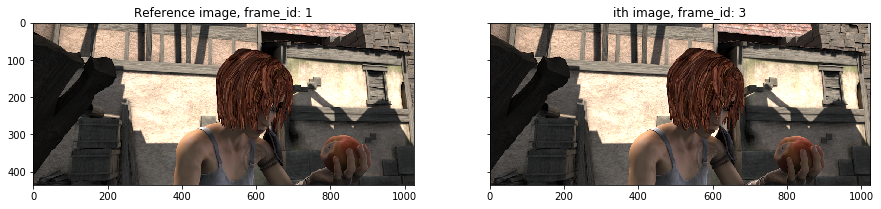

In [33]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.set_figheight(15)
fig.set_figwidth(15)
ax1.imshow(tgm.utils.tensor_to_image(img_ref)[:,:,::-1])
ax1.set_title('Reference image, frame_id: %d' %frame_ref_id)
ax2.imshow(tgm.utils.tensor_to_image(img_i)[:,:,::-1])
ax2.set_title('ith image, frame_id: %d' %frame_i_id)
plt.show()

### instantiate the depth warper from torchgeometry

In [37]:
warper = tgm.DepthWarper(cam_i)
warper.compute_homographies(cam_ref)

# compute the inverse depth and warp the source image                                                                                
inv_depth_ref = 1. / depth_ref
img_i_to_ref = warper(inv_depth_ref, img_i)

# generate occlusion mask                                                                                                            
mask = ((img_ref - img_i_to_ref).mean(1) < 1e-1).float()

img_vis_warped = 0.5 * img_i_to_ref + img_ref
img_vis_warped_masked = mask * (0.5 * img_i_to_ref + img_ref)

### Visualization: output

TypeError: squeeze(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

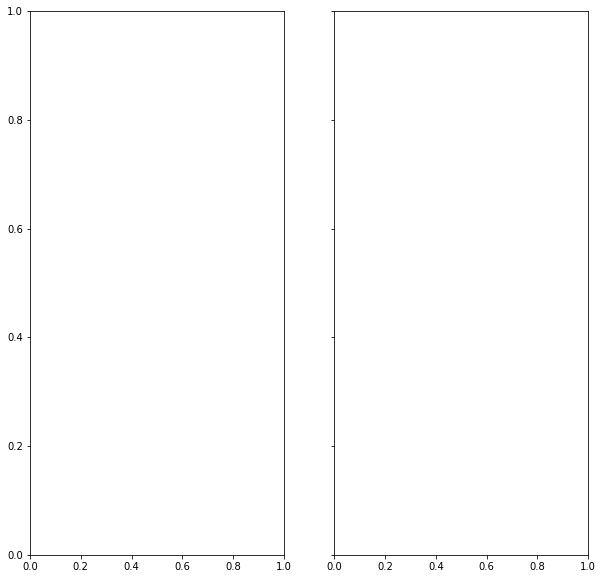

In [39]:
def clip_and_convert_tensor(tensor):
    img = tgm.utils.tensor_to_image(255. * tensor) # convert tensor to numpy
    img_cliped = np.clip(img, 0, 255)[:,:,::-1] # clip and reorder the channels
    img = img_cliped.astype('uint') # convert to uint
    return img
 
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.set_figheight(10)
fig.set_figwidth(10)
ax1.imshow(clip_and_convert_tensor(warped_image))
ax1.set_title('Original warped image')
ax2.imshow(clip_and_convert_tensor(img_vis_warped_masked)
ax2.set_title('with occlusion mask')
plt.show()

In [40]:
img_vis_warped_masked

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 1.0342, 1.0392, 1.0397],
          [0.0000, 0.0000, 0.0000,  ..., 1.0353, 1.0353, 1.0354],
          [0.0000, 0.0000, 0.0000,  ..., 1.0353, 1.0353, 1.0359],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1815, 0.1922, 0.1939],
          [0.0000, 0.0000, 0.0000,  ..., 0.1878, 0.1984, 0.1936],
          [0.0000, 0.0000, 0.0000,  ..., 0.1578, 0.1628, 0.1583]],

         [[0.0000, 0.0000, 0.0000,  ..., 1.0927, 1.0939, 1.0941],
          [0.0000, 0.0000, 0.0000,  ..., 1.0884, 1.0930, 1.0941],
          [0.0000, 0.0000, 0.0000,  ..., 1.0928, 1.0941, 1.0941],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1884, 0.1991, 0.2000],
          [0.0000, 0.0000, 0.0000,  ..., 0.1937, 0.2043, 0.1995],
          [0.0000, 0.0000, 0.0000,  ..., 0.1589, 0.1638, 0.1633]],

         [[0.0000, 0.0000, 0.0000,  ..., 1.1118, 1.1118, 1.1118],
          [0.0000, 0.0000, 0.0000,  ..., 1.1118, 1.1118, 1.1119],
          [0.0000, 0.0000, 0.0000,  ..., 1